# Z-Score Based Anomaly Detection on Time-Series Data

**Dataset**: complex.csv  
**Author**: Alireza Montazeri (223632922)

---

## Introduction

Anomaly detection identifies unusual patterns or outliers in data. In time series, these anomalies can signify critical events like system failures, cyber-attacks, or unexpected opportunities.

## Z-score Algorithm Explained

The **Z-score** measures how far a data point is from the mean in terms of standard deviations:

$z = \frac{x - \mu}{\sigma}$

Where:  
- $x$ = current value  
- $\mu$ = mean of the data  
- $\sigma$ = standard deviation

In time-series, nearby data points tend to be more similar than far away data points. That means most of the time the best context is last `n` sample of data given a data point we want to evaluate. Or if we want to take into account seasonality, the same period of time for the previous day, month or year.

A very basic anomaly detection algorithm would be:

- Take `n` sample of data prior to a given timestamp.
- Remove outliers from the sample, and calculate the average and standard deviation of the metric (we could use median based statistics as well).
- Calculate the Z-score for a series of data points, comparing to the context average and standard deviation.
- To avoid locality in the anomalies, do some aggreggations. For instance, you can work in groups of ten seconds and consider an anomaly if the Z-score is beyond the threshold during a period of time.
- Return `0` or `1` depending on the Z-score value, a threshold of ±2 would work.

## Implementation

Now, let's implement the Z-score based anomaly detection algorithm and test it on our dataset (`complex.csv`). 

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('complex.csv')
df.head()

,time,s1,s2,s3
0,0,1.000000,2.00000,0.700000
1,1,1.010000,1.99995,0.707000
2,2,1.019999,1.99980,0.713999
3,3,1.029996,1.99955,0.720997
4,4,1.039989,1.99920,0.727993


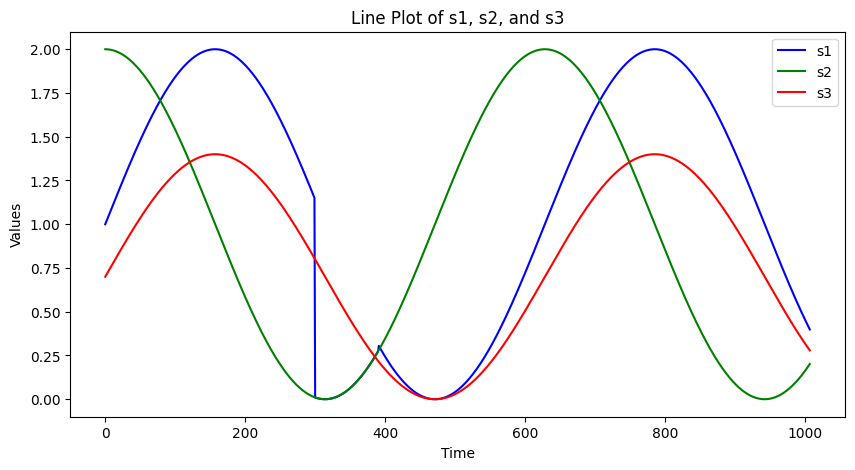

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['s1'], label='s1', color='blue')
plt.plot(df['time'], df['s2'], label='s2', color='green')
plt.plot(df['time'], df['s3'], label='s3', color='red')
plt.title('Line Plot of s1, s2, and s3')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

The plot shows time series data for s1, s2, and s3, all following smooth, periodic patterns. However, s1 exhibits a clear anomaly around time index ~300, where it abruptly drops to near zero—unlike s2 and s3, which remain stable. This confirms the presence of an isolated anomaly in s1 that warrants further investigation using algorithmic detection.

### Z-score Anomaly Detection Function

In [5]:
class ZScoreAnomalyDetection:
    def __init__(self, df=None, window_size=30, z_thresh=2.5):
        """
        Initialize the detector.

        Parameters:
        - df: Optional pandas DataFrame with 'time' and value columns.
        - window_size: Rolling window size.
        - z_thresh: Z-score threshold.
        """
        self.window_size = window_size
        self.z_thresh = z_thresh

        if df is not None:
            self.df = df.copy()
        else:
            self.df = pd.DataFrame(columns=['time', 'value'])
        
    def is_anomaly(self, time_step, value):
        """
        Check if the given value at time_step is an anomaly.

        If initialized with a DataFrame, use the historical data.
        Otherwise, add the incoming data to internal DataFrame.

        Parameters:
        - time_step: The time or index of the value.
        - value: The actual value to check.

        Returns:
        - True if anomaly, False otherwise.
        """
        # If streaming mode, append new data
        if self.df.empty or 'value' not in self.df.columns:
            self.df = pd.DataFrame(columns=['time', 'value'])

        if time_step not in self.df['time'].values:
            new_row = pd.DataFrame({'time': [time_step], 'value': [value]})
            self.df = pd.concat([self.df, new_row], ignore_index=True)

        # Sort by time just in case
        self.df = self.df.sort_values(by='time').reset_index(drop=True)

        # Get the index of the current time_step
        idx = self.df[self.df['time'] == time_step].index[0]

        # Need enough previous points to compute rolling statistics
        if idx < self.window_size:
            return False  # Not enough data yet

        # Extract the last 'window_size' number of values *before or including* current
        window_data = self.df.loc[idx - self.window_size + 1: idx, 'value']

        # Calculate mean and std manually
        mean = window_data.mean()
        std = window_data.std()

        # If std is zero, we can't compute a Z-score
        if std == 0:
            return False

        # Calculate Z-score
        z = (self.df.loc[idx, 'value'] - mean) / std

        return abs(z) > self.z_thresh


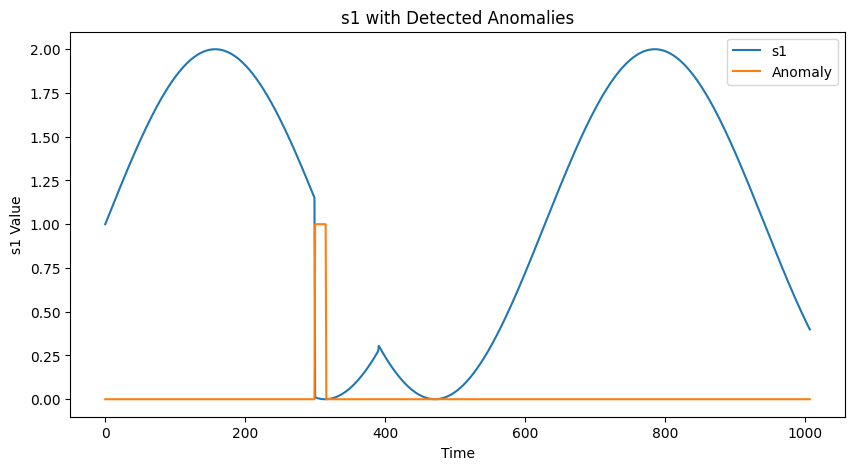

In [6]:
# Using the original dataframe for s1
detector = ZScoreAnomalyDetection(df[['time', 's1']].rename(columns={'s1': 'value'}), window_size=200, z_thresh=3)

# Detected anomalies
anomalies = [detector.is_anomaly(row['time'], row['s1']) for _, row in df.iterrows()]

# Plot the original s1 values and the detected anomalies
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['s1'], label='s1')
plt.plot(df['time'], anomalies, label='Anomaly')

plt.title('s1 with Detected Anomalies')
plt.xlabel('Time')
plt.ylabel('s1 Value')
plt.legend()
plt.show()

C:\Users\Alireza\AppData\Local\Temp\ipykernel_3296\817589446.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, new_row], ignore_index=True)


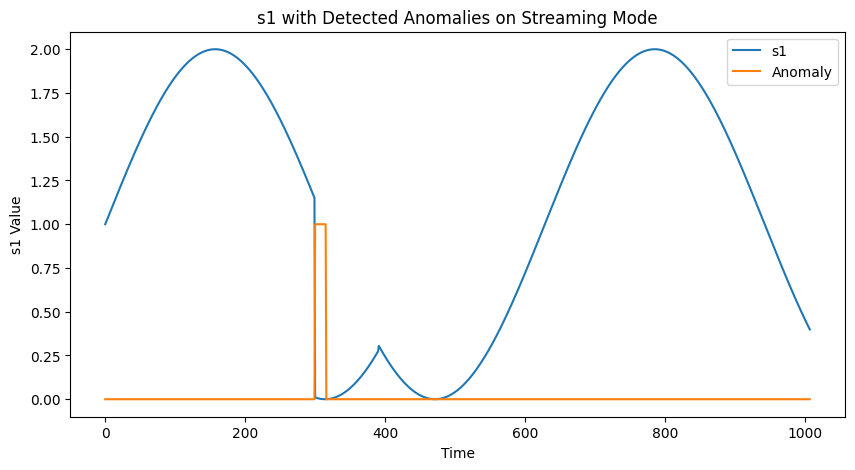

In [7]:
# Streaming mode: no dataframe at start
detector_stream = ZScoreAnomalyDetection(window_size=200, z_thresh=3)

# Detect anomalies in streaming mode
anomalies = [detector_stream.is_anomaly(t, v) for t, v in zip(df['time'], df['s1'])]

# Plot the original s1 values and anomalies detected in streaming mode
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['s1'], label='s1')
plt.plot(df['time'], anomalies, label='Anomaly')

plt.title('s1 with Detected Anomalies on Streaming Mode')
plt.xlabel('Time')
plt.ylabel('s1 Value')
plt.legend()
plt.show()

From the plots of both methods—using historical data and streaming—we can see that anomalies in s1 are correctly detected around the sudden drop near time step ~300, while the rest of the signal follows the expected sinusoidal pattern without false positives. This confirms that the Z-score method, with the same parameters (threshold = 3 and window size = 200), effectively identifies significant deviations without over-flagging normal fluctuations.


## Conclusion

**Is Z-score suitable for our future project?** Yes, with considerations.

| Pros                                     | Cons                                          |
|------------------------------------------|-----------------------------------------------|
| Fast and simple                          | Struggles with trends and seasonality         |
| Interpretable results                    | Sensitive to window size and threshold tuning |
| Only requires the current data itself    |                                               |

**Best Use Cases for Z-score:** Best for stationary data without complex seasonality.

- Detecting sudden spikes/drops in metrics.
- Network traffic anomaly detection.
- Industrial sensor data monitoring.
- Financial fraud detection. 

**Next Steps**:
- Integrate Z-score anomaly detection into the data pipeline.
- Monitor and fine-tune the rolling window and threshold.
- Consider combining with complementary methods for robustness.


### References

1. **Chandola, V., Banerjee, A., & Kumar, V. (2009).**
   *Anomaly Detection: A Survey.* ACM Computing Surveys (CSUR), 41(3), 1–58.
   [https://doi.org/10.1145/1541880.1541882](https://doi.org/10.1145/1541880.1541882)
   *(A comprehensive survey on anomaly detection techniques across different domains.)*

2. **Ahmed, M., Mahmood, A. N., & Hu, J. (2016).**
   *A Survey of Network Anomaly Detection Techniques.* Journal of Network and Computer Applications, 60, 19–31.
   [https://doi.org/10.1016/j.jnca.2015.11.016](https://doi.org/10.1016/j.jnca.2015.11.016)
   *(Covers statistical, machine learning, and knowledge-based anomaly detection methods, including Z-score techniques.)*

3. **Twitter Inc. (2015).**
   *AnomalyDetection: Anomaly Detection Using Seasonal Hybrid Extreme Studentized Deviate Test.*
   [GitHub Repository](https://github.com/twitter/AnomalyDetection)
   *(Demonstrates practical time series anomaly detection using statistical methods inspired by Z-score.)*

4. **Blázquez-García, A., Conde, A., Mori, U., & Lozano, J. A. (2021).**
   *A Review on Outlier/Anomaly Detection in Time Series Data.* ACM Computing Surveys (CSUR), 54(3), 1–33.
   [https://doi.org/10.1145/3439950](https://doi.org/10.1145/3439950)
   *(A recent and thorough review of anomaly detection approaches specifically for time series, including statistical techniques like Z-score.)*

5. **Aggarwal, C. C. (2017).**
   *Outlier Analysis.* Springer.
   *(A key textbook covering outlier detection methods, including traditional statistical methods like Z-score.)*